# Library

In [1]:
#Pytorch library
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, threshold=10, edgeitems=5, suppress=True)
torch.set_printoptions(precision=3, threshold=10, edgeitems=5, sci_mode=False)

# Data preprocessing library

In [2]:
def normalize_dataset(x, y):
  x_mean = torch.mean(x)
  y_mean = torch.mean(y)
  x_std = torch.std(x)
  y_std = torch.std(y)
  x = (x-torch.mean(x))/torch.std(x)
  y = (y-torch.mean(y))/torch.std(y)
  x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
  y = torch.where(torch.isnan(y), torch.zeros_like(y), y)
  return x, y, x_mean, y_mean, x_std, y_std

def normalize_input(x, x_mean, x_std):
  return (x-x_mean)/x_std

def denormalize_output(y, y_mean, y_std):
  return y*y_std+y_mean

def slice_dataset(x_dataset, y_dataset, n_train_percent):
  data_size = len(x_dataset)
  x_train = x_dataset[:int(data_size*n_train_percent)]
  x_test = x_dataset[int(data_size*n_train_percent):]
  y_train = y_dataset[:int(data_size*n_train_percent)]
  y_test = y_dataset[int(data_size*n_train_percent):]
  return x_train, y_train, x_test, y_test

# power flow dataset

In [3]:
df = pd.read_excel('gnn_dataset.xlsx')
df.head

<bound method NDFrame.head of    PF Dataset  Bus1_Pgen  Bus1_Qgen  Bus1_Vgen  Bus1_dgen  Bus2_Pgen  \
0      Data 1    252.130     57.136      9.907          0      163.0   
1      Data 2    265.068     50.663      9.907          0      163.0   
2      Data 3    127.246     15.918      9.907          0      163.0   
3      Data 4    384.471    110.843      9.907          0      163.0   
4      Data 5    283.846     70.385      9.907          0      163.0   
..        ...        ...        ...        ...        ...        ...   
95    Data 96    260.495     69.772      9.907          0      163.0   
96    Data 97    154.545     26.128      9.907          0      163.0   
97    Data 98    238.472     60.046      9.907          0      163.0   
98    Data 99    288.899     71.200      9.907          0      163.0   
99   Data 100    226.043     55.963      9.907          0      163.0   

    Bus2_Qgen  Bus2_Vgen  Bus2_dgen  Bus3_Pgen  ...  Bus7_Vload  Bus7_dload  \
0      29.579     10.652  

In [4]:
n_node = 9
dataset_length = len(df.index)

data_x, data_y = [], []
x_raw, y_raw = [], []
for row in range(dataset_length):
  for col in range(n_node):
    if col == 0:
      data_x.append(list([df.iloc[row, 3], df.iloc[row, 4]]))
      data_y.append(list([df.iloc[row, 1], df.iloc[row, 2]]))
    elif col == 1 or col == 2:
      data_x.append(list([df.iloc[row, col*4+1], df.iloc[row, col*4+3]]))
      data_y.append(list([df.iloc[row, col*4+2], df.iloc[row, col*4+4]]))
    else:
      data_x.append(list([df.iloc[row, col*4+1], df.iloc[row, col*4+2]]))
      data_y.append(list([df.iloc[row, col*4+3], df.iloc[row, col*4+4]]))
  x_raw.append(list(data_x))
  y_raw.append(list(data_y))
  data_x, data_y = [], []

x_raw = torch.tensor(x_raw, dtype=torch.float)
y_raw = torch.tensor(y_raw, dtype=torch.float)

In [5]:
n_train_percent = 0.5

x_raw_train, y_raw_train, x_raw_test, y_raw_test = slice_dataset(x_raw, y_raw, n_train_percent)
x, y, x_mean, y_mean, x_std, y_std = normalize_dataset(x_raw, y_raw)
x_train, y_train, x_test, y_test = slice_dataset(x, y, n_train_percent)

# GNN

In [6]:
class MyGNN(nn.Module):
  def __init__(self, input_size=None, hidden_size1=None, hidden_size2=None, output_size=None, Adj=None, lr=None, betas=None, eps=None):
    super(MyGNN, self).__init__()
    self.input_size = input_size if input_size is not None else 2
    self.hidden_size1 = hidden_size1 if hidden_size1 is not None else 32
    self.hidden_size2 = hidden_size2 if hidden_size1 is not None else 16
    self.output_size = output_size if output_size is not None else 2

    I = torch.eye(Adj.shape[0])
    self.Adj_I = Adj + I
    D = torch.diag(torch.sum(self.Adj_I, axis=0))
    D_inv = D ** -(0.5)
    self.D_inv = torch.where(torch.isinf(D_inv), torch.zeros_like(D_inv), D_inv)

    #Xavier initialization for model parameter
    b1 = torch.randn(1, self.hidden_size1) * torch.sqrt(torch.tensor(2)/(1+self.hidden_size1))
    b2 = torch.randn(1, self.hidden_size2) * torch.sqrt(torch.tensor(2)/(1+self.hidden_size2))
    b3 = torch.randn(1, self.output_size) * torch.sqrt(torch.tensor(2)/(1+self.output_size))
    w1 = torch.randn(self.input_size, self.hidden_size1) * torch.sqrt(torch.tensor(2)/(self.input_size+self.hidden_size1))
    w2 = torch.randn(self.hidden_size1, self.hidden_size2) * torch.sqrt(torch.tensor(2)/(self.hidden_size1+self.hidden_size2))
    w3 = torch.randn(self.hidden_size2, self.output_size) * torch.sqrt(torch.tensor(2)/(self.hidden_size2+self.output_size))

    #set model parameters require gradient
    self.b1 = b1.clone().detach().requires_grad_(True)
    self.w1 = w1.clone().detach().requires_grad_(True)
    self.b2 = b2.clone().detach().requires_grad_(True)
    self.w2 = w2.clone().detach().requires_grad_(True)
    self.b3 = b3.clone().detach().requires_grad_(True)
    self.w3 = w3.clone().detach().requires_grad_(True)
    
    #train iteration
    self.t = 0 
    
    #learning rate
    self.lr = lr if lr is not None else 0.001

    #gradient momentum (running average)
    self.beta1 = betas[0] if betas is not None else 0.9
    self.Vdb1, self.Vdb2, self.Vdb3, self.Vdw1, self.Vdw2, self.Vdw3 = 0, 0, 0, 0, 0, 0
    
    #gradient RMSprop
    self.beta2 = betas[1] if betas is not None else 0.999
    self.Sdb1, self.Sdb2, self.Sdb3, self.Sdw1, self.Sdw2, self.Sdw3 = 0, 0, 0, 0, 0, 0
    self.eps = eps if eps is not None else 1e-8

  def GCN_layer(self, x):
    self.aggregator = torch.matmul(torch.matmul(self.D_inv, self.Adj_I), self.D_inv)

    self.aggregated1 = torch.matmul(self.aggregator, x)
    self.z1 = torch.matmul(self.aggregated1, self.w1) + self.b1
    self.a1 = torch.tanh(self.z1)
    
    self.aggregated2 = torch.matmul(self.aggregator, self.a1)
    self.z2 = torch.matmul(self.aggregated2, self.w2) + self.b2
    self.a2 = torch.tanh(self.z2)
    
    self.aggregated3 = torch.matmul(self.aggregator, self.a2)
    self.z3 = torch.matmul(self.aggregated3, self.w3) + self.b3
    self.a3 = self.z3

    return self.a3

  def ADAM_step(self):
    self.t += 1

    with torch.no_grad():
      
      #gradient momentum (running average)
      self.Vdb1 = self.beta1*self.Vdb1 + self.b1.grad*(1-self.beta1)
      self.Vdb2 = self.beta1*self.Vdb2 + self.b2.grad*(1-self.beta1)
      self.Vdb3 = self.beta1*self.Vdb3 + self.b3.grad*(1-self.beta1)
      self.Vdw1 = self.beta1*self.Vdw1 + self.w1.grad*(1-self.beta1)
      self.Vdw2 = self.beta1*self.Vdw2 + self.w2.grad*(1-self.beta1)
      self.Vdw3 = self.beta1*self.Vdw3 + self.w3.grad*(1-self.beta1)

      #gradient RMSprop
      self.Sdb1 = self.beta2*self.Sdb1 + self.b1.grad*self.b1.grad*(1-self.beta2)
      self.Sdb2 = self.beta2*self.Sdb2 + self.b2.grad*self.b2.grad*(1-self.beta2)
      self.Sdb3 = self.beta2*self.Sdb3 + self.b3.grad*self.b3.grad*(1-self.beta2)
      self.Sdw1 = self.beta2*self.Sdw1 + self.w1.grad*self.w1.grad*(1-self.beta2)
      self.Sdw2 = self.beta2*self.Sdw2 + self.w2.grad*self.w2.grad*(1-self.beta2)
      self.Sdw3 = self.beta2*self.Sdw3 + self.w3.grad*self.w3.grad*(1-self.beta2)

      #corrected value
      self.Vdb1_corr = self.Vdb1/(1-(self.beta1**self.t))
      self.Vdb2_corr = self.Vdb2/(1-(self.beta1**self.t))
      self.Vdb3_corr = self.Vdb3/(1-(self.beta1**self.t))
      self.Vdw1_corr = self.Vdw1/(1-(self.beta1**self.t))
      self.Vdw2_corr = self.Vdw2/(1-(self.beta1**self.t))
      self.Vdw3_corr = self.Vdw3/(1-(self.beta1**self.t))
      self.Sdb1_corr = self.Sdb1/(1-(self.beta2**self.t))
      self.Sdb2_corr = self.Sdb2/(1-(self.beta2**self.t))
      self.Sdb3_corr = self.Sdb3/(1-(self.beta2**self.t))
      self.Sdw1_corr = self.Sdw1/(1-(self.beta2**self.t))
      self.Sdw2_corr = self.Sdw2/(1-(self.beta2**self.t))
      self.Sdw3_corr = self.Sdw3/(1-(self.beta2**self.t))

      #adam optimizer parameter update
      self.b1 -= self.lr*self.Vdb1_corr/(torch.sqrt(self.Sdb1_corr)+self.eps)
      self.b2 -= self.lr*self.Vdb2_corr/(torch.sqrt(self.Sdb2_corr)+self.eps)
      self.b3 -= self.lr*self.Vdb3_corr/(torch.sqrt(self.Sdb3_corr)+self.eps)
      self.w1 -= self.lr*self.Vdw1_corr/(torch.sqrt(self.Sdw1_corr)+self.eps)
      self.w2 -= self.lr*self.Vdw2_corr/(torch.sqrt(self.Sdw2_corr)+self.eps)
      self.w3 -= self.lr*self.Vdw3_corr/(torch.sqrt(self.Sdw3_corr)+self.eps)

      #set zero grad before next backprop 
      self.b1.grad.zero_()
      self.b2.grad.zero_()
      self.b3.grad.zero_()
      self.w1.grad.zero_()
      self.w2.grad.zero_()
      self.w3.grad.zero_()
  
  def save_weights(self, model):
     torch.save(model, "model")

In [7]:
x_train, y_train = x_train, y_train
x_test, y_test = x_test, y_test
Adj = torch.tensor([[0,0,0,1,0,0,0,0,0],
                  [0,0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,0,1],
                  [1,0,0,0,1,1,0,0,0],
                  [0,0,0,1,0,0,1,0,0],
                  [0,0,0,1,0,0,0,0,1],
                  [0,1,0,0,1,0,0,1,0],
                  [0,0,0,0,0,0,1,0,1],
                  [0,0,1,0,0,1,0,1,0]], dtype=torch.long)

input_size = 2
hidden_size1 = 32
hidden_size2 = 16
output_size = 2
lr = 0.005
betas = [0.9, 0.999]
eps = 1e-8


In [8]:
%%time
#batching one by one for 100 data spend 12 minutes 
model = MyGNN(input_size, hidden_size1, hidden_size2, output_size, Adj, lr, betas, eps)
train_loss_list, test_loss_list = [], []

for epoch in range(3001):

  train_loss = 0
  for i,_ in enumerate(x_train):
    y_train_prediction = model.GCN_layer(x_train[i])
    loss = F.mse_loss(denormalize_output(y_train_prediction, y_mean, y_std), denormalize_output(y_train[i], y_mean, y_std))
    loss.backward()
    model.ADAM_step()
    train_loss += loss
  train_loss /= len(x_train)
  train_loss_list.append(train_loss)

  with torch.no_grad():
    test_loss = 0
    for j,_ in enumerate(x_test):
      y_test_prediction = model.GCN_layer(x_test[j])
      loss = F.mse_loss(denormalize_output(y_test_prediction, y_mean, y_std), denormalize_output(y_test[j], y_mean, y_std))
      test_loss += loss
    test_loss /= len(x_test)
    test_loss_list.append(test_loss)

  if (epoch % 300) == 0:
    print('epoch: {:5d}    train loss: {:.5f}    test loss: {:.5f}'.format(epoch, train_loss, test_loss))

epoch:     0    train loss: 3495.00977    test loss: 3183.61475
epoch:   300    train loss: 782.19482    test loss: 766.23315
epoch:   600    train loss: 545.69751    test loss: 664.12323
epoch:   900    train loss: 449.46735    test loss: 723.17151
epoch:  1200    train loss: 376.93991    test loss: 706.54297
epoch:  1500    train loss: 359.34357    test loss: 900.73499
epoch:  1800    train loss: 366.89249    test loss: 936.14093
epoch:  2100    train loss: 296.16681    test loss: 1040.32605
epoch:  2400    train loss: 274.34241    test loss: 1231.42529
epoch:  2700    train loss: 236.31573    test loss: 1398.93958
epoch:  3000    train loss: 236.20856    test loss: 1451.58813
Wall time: 3min 30s


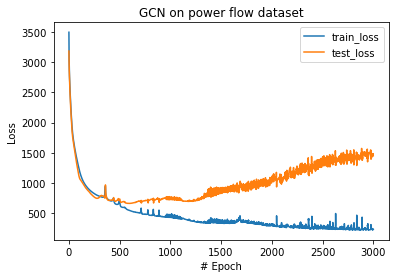

Epoch: 3000, Train loss: 236.20856, Test loss: 1451.58813


In [9]:
plt.title('GCN on power flow dataset')
plt.plot(train_loss_list, label="train_loss")
plt.plot(test_loss_list, label="test_loss")
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

print('Epoch: {:03d}, Train loss: {:.5f}, Test loss: {:.5f}'.
          format(epoch, train_loss, test_loss))

In [10]:
with torch.no_grad(): y_train_prediction = model.GCN_layer(x_train[0])
train_loss_1 = F.mse_loss(denormalize_output(y_train_prediction, y_mean, y_std), denormalize_output(y_train[0], y_mean, y_std))
print("Train output: \n" + str(denormalize_output(y_train, y_mean, y_std).detach().numpy()[0]))
print()
print("Train output prediction: \n" + str(denormalize_output(y_train_prediction, y_mean, y_std).detach().numpy()))
print('Train loss (MSE): {:.5f}'.format(train_loss_1))
print()
print("==========================")
print()
with torch.no_grad(): y_test_prediction = model.GCN_layer(x_test[-1])
test_loss_1 = F.mse_loss(denormalize_output(y_test_prediction, y_mean, y_std), denormalize_output(y_test[-1], y_mean, y_std))
print("Test output: \n" + str(denormalize_output(y_test, y_mean, y_std).detach().numpy()[-1]))
print()
print("Test output prediction: \n" + str(denormalize_output(y_test_prediction, y_mean, y_std).detach().numpy()))
print('Test loss (MSE): {:.5f}'.format(test_loss_1))

Train output: 
[[252.13   57.136]
 [ 29.579  -4.824]
 [ 31.966 -12.65 ]
 [135.178 142.116]
 [134.258 139.763]
 [132.894 135.852]
 [134.365 139.539]
 [132.437 135.263]
 [133.839 134.587]]

Train output prediction: 
[[266.65   65.7  ]
 [ 34.625 -10.789]
 [ 47.672 -12.399]
 [169.642 155.119]
 [149.174 144.078]
 [135.924 134.616]
 [134.825 137.902]
 [136.747 131.852]
 [132.182 130.275]]
Train loss (MSE): 125.27916


Test output: 
[[226.043  55.963]
 [ 61.89   -4.06 ]
 [ 49.702  -7.021]
 [135.014 142.927]
 [134.027 139.523]
 [130.995 138.661]
 [131.762 140.192]
 [130.299 138.681]
 [132.494 140.188]]

Test output prediction: 
[[273.523  65.801]
 [ 78.146  -1.805]
 [ 16.114 -20.34 ]
 [116.414 137.059]
 [100.627 128.005]
 [ 98.567 127.934]
 [105.729 129.959]
 [ 90.926 126.52 ]
 [ 87.181 123.758]]
Test loss (MSE): 640.28522
